In [1]:
using HTTP
using JSON
using DataFrames
using Dates
using TimeSeries

In [18]:
include("../env.jl")

"VVp9vMTjNvSEUqJJuqpRLw5r4oUq2uFGbX2VipCE"

In [19]:
function wgetStock(sym::String)
    fromTime =  Dates.format(now()-Day(500), "yyyy-mm-ddTHH:MM:SS")
    @show fromTime
    headers = ["APCA-API-KEY-ID" => ENV["APCA-API-KEY-ID"], "APCA-API-SECRET-KEY" => ENV["APCA-API-SECRET-KEY"] ]
    url_query = "https://data.alpaca.markets/v1/bars/day?symbols="*sym*"&after="*fromTime*"&limit=500"
    raw_response = HTTP.request("GET", url_query, headers)
    rsp = JSON.parse(String(raw_response.body))
    df2 = DataFrame(t = Int[],h = Float32[],l = Float32[],o = Float32[],c = Float32[],v = Float32[] )
    for (sym,v) in rsp
        for q in v
            push!(df2,q)
        end
    end
    transform!(df2, :t => ( x -> Dates.unix2datetime.(x) ) => :ondate)
    DataFrames.rename!(df2,:h => :High)
    DataFrames.rename!(df2,:l => :Low)
    DataFrames.rename!(df2,:o => :Open)
    DataFrames.rename!(df2,:c => :Close)
    DataFrames.rename!(df2,:v => :Volume)
    sort!(df2,order(:ondate))
    return select(df2,[:Open,:Close,:High,:Low,:Volume,:ondate])
end

wgetStock (generic function with 1 method)

In [20]:
tick1="GLD"
df1 = wgetStock(tick1)
tick2="IAU"
df2 = wgetStock(tick2)

fromTime = "2020-01-28T16:37:29"
fromTime = "2020-01-28T16:37:34"


,Open,Close,High,Low,Volume,ondate
,Float32,Float32,Float32,Float32,Float32,DateTime
1,12.9,12.835,12.95,12.8013,1.97872e7,2019-06-14T04:00:00
2,12.85,12.825,12.86,12.793,1.15651e7,2019-06-17T04:00:00
3,12.93,12.88,12.96,12.82,2.32213e7,2019-06-18T04:00:00
4,12.86,12.965,12.98,12.32,2.38345e7,2019-06-19T04:00:00
5,13.22,13.295,13.34,12.405,2.45128e7,2019-06-20T04:00:00
6,13.37,13.39,13.405,13.29,1.66859e7,2019-06-21T04:00:00
7,13.47,13.58,13.59,13.44,2.22944e7,2019-06-24T04:00:00
8,13.69,13.61,13.75,12.86,5.52916e7,2019-06-25T04:00:00
9,13.5,13.48,13.55,13.43,1.58035e7,2019-06-26T04:00:00


In [21]:
using Pkg 
Pkg.add("StatsBase")
using StatsBase
Pkg.add("HypothesisTests")
using HypothesisTests

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [22]:

using Plots
function testStationary(df)
    y = autocor(df,1:20)
    display(bar(y))
    y = pacf(df,1:20)
    display(bar(y))
    ADFTest(df,:none,1)
end

testStationary (generic function with 1 method)

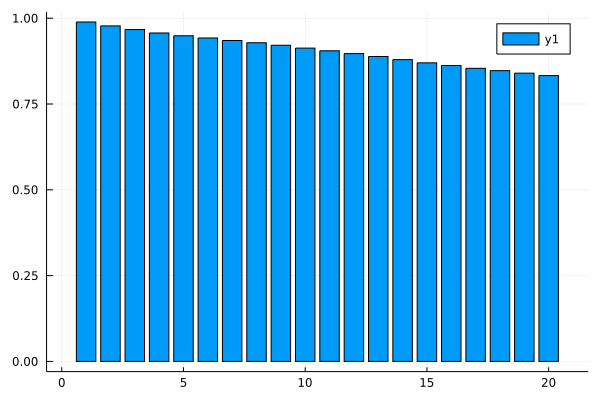

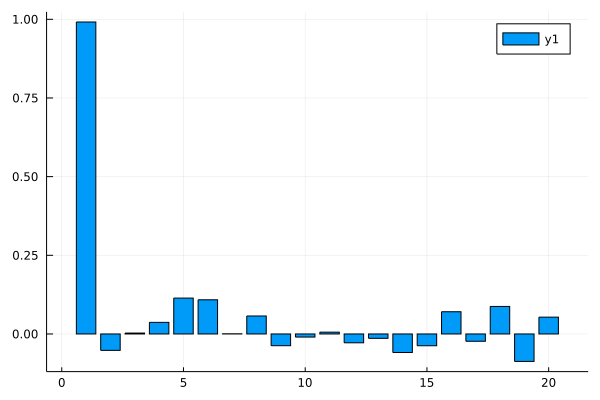

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          0.000502098

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.9205

Details:
    sample size in regression:          498
    number of lags:                     1
    ADF statistic:                      1.03345
    Critical values at 1%, 5%, and 10%: [-2.57023 -1.94155 -1.6163]


In [23]:
testStationary(df1[!,:Close])

In [24]:
Pkg.add("TimeSeries")
using TimeSeries

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [25]:
ta1 = TimeArray(df1;timestamp = :ondate)
ta2 = TimeArray(df2;timestamp = :ondate)
merge(ta1[:Close],ta2[:Close],colnames = [:Close1,:Close2])

498×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-06-18T04:00:00 to 2021-06-10T04:00:00
│                     │ Close1 │ Close2 │
├─────────────────────┼────────┼────────┤
│ 2019-06-18T04:00:00 │ 127.04 │ 12.88  │
│ 2019-06-19T04:00:00 │ 127.89 │ 12.965 │
│ 2019-06-20T04:00:00 │ 131.12 │ 13.295 │
│ 2019-06-21T04:00:00 │ 132.0  │ 13.39  │
│ 2019-06-24T04:00:00 │ 133.94 │ 13.58  │
│ 2019-06-25T04:00:00 │ 134.2  │ 13.61  │
│ 2019-06-26T04:00:00 │ 132.97 │ 13.48  │
│ 2019-06-27T04:00:00 │ 132.84 │ 13.48  │
│ 2019-06-28T04:00:00 │ 133.17 │ 13.505 │
│ 2019-07-01T04:00:00 │ 130.6  │ 13.25  │
│ 2019-07-02T04:00:00 │ 133.38 │ 13.53  │
│ 2019-07-03T04:00:00 │ 133.64 │ 13.56  │
   ⋮
│ 2021-05-26T04:00:00 │ 177.63 │ 36.135 │
│ 2021-05-27T04:00:00 │ 177.78 │ 36.16  │
│ 2021-05-28T04:00:00 │ 178.31 │ 36.26  │
│ 2021-06-01T04:00:00 │ 177.93 │ 36.2   │
│ 2021-06-02T04:00:00 │ 178.75 │ 36.37  │
│ 2021-06-03T04:00:00 │ 175.25 │ 35.645 │
│ 2021-06-04T04:00:00 │ 177.17 │ 36.04  │
│ 2021-06-07T04

In [45]:
pct1 = percentchange(ta1[:Close])
pct2 = percentchange(ta2[:Close])
pct = merge(pct1,pct2)
TimeSeries.rename!(pct,:Close => :Close1)
TimeSeries.rename!(pct,:Close_1 => :Close2)
dif = TimeSeries.rename(pct[:Close1] .- pct[:Close2], :Close1_Close2 => :Diff) 
data = merge(pct,dif)
df = DataFrame(data[3:9])
current = DataFrame(data[10])
@show df[3,:Close1]
@show size(current)
current[1,:Close1]

df[3, :Close1] = 0.0019411783f0
size(current) = (1, 4)


0.021286238f0

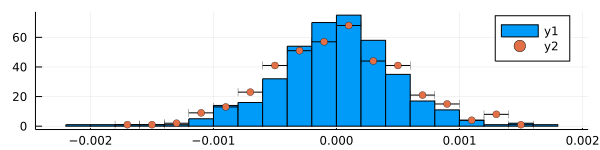

In [84]:
using Random, Distributions
using StatsBase
df = DataFrame(data)
df = filter(:Diff => x -> x > -0.01, df)
histogram(df[1:400,:Diff])
fit(Normal, df[1:400,:Diff])

plot!(rand(Normal(-9.9e-6, 0.00052), 400), seriestype=:scatterhist, linestyle=:solid, size=(600,150))

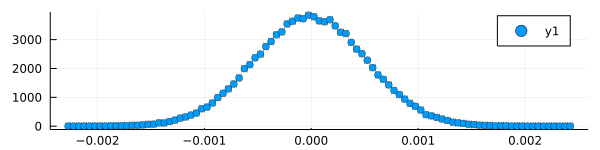

In [79]:
using StatsBase
plot(rand(Normal(-9.932578905136324e-6, 0.0005236135785349126), 100000), seriestype=:scatterhist, linestyle=:solid, size=(600,150))

In [83]:
filter(:Diff => x -> x > -0.01, df)

,timestamp,Close1,Close2,Diff
,DateTime,Float32,Float32,Float32
1,2019-06-19T04:00:00,0.00669085,0.00659941,9.1441e-5
2,2019-06-20T04:00:00,0.0252561,0.0254531,-0.000197038
3,2019-06-21T04:00:00,0.00671149,0.00714554,-0.000434048
4,2019-06-24T04:00:00,0.0146967,0.0141898,0.000506943
5,2019-06-25T04:00:00,0.00194118,0.002209,-0.000267822
6,2019-06-26T04:00:00,-0.00916546,-0.00955187,0.000386403
7,2019-06-27T04:00:00,-0.000977515,0.0,-0.000977515
8,2019-06-28T04:00:00,0.00248406,0.00185471,0.000629357
9,2019-07-01T04:00:00,-0.0192983,-0.018882,-0.000416283


In [11]:
testStationary(data[!,:Close])

LoadError: UndefVarError: data not defined

In [12]:
testStationary(DataFrame(pct1[:Close])[!,:Close])

LoadError: UndefVarError: pct1 not defined

In [13]:
for (row_index,row) in enumerate(eachrow(pct))
    @show row.timestamp
    @show row.Close
    @show row_index
    
end

LoadError: UndefVarError: pct not defined

In [14]:
N = length(pct)

LoadError: UndefVarError: pct not defined

In [15]:
for i in 2:N
    @show values(pct[i-1:i,:Close])
end

LoadError: UndefVarError: N not defined

In [16]:

function BuyOrSell(ta1,ta2,i,lookback)
    pct1 = percentchange(ta1[:Close])
    pct2 = percentchange(ta2[:Close])
    pct = merge(pct1,pct2)
    TimeSeries.rename!(pct,:Close => :Close1)
    TimeSeries.rename!(pct,:Close_1 => :Close2)
    dif = TimeSeries.rename(pct[:Close1] .- pct[:Close_2], :Close1_Close2 => :Diff) 
    data = merge(pct,dif)
    
    df = DataFrame(data[i-lookbak:i-1])
    current = DataFrame(data[i])
    
    mean1 = 
    std1 =  
    mean12 = 
    std12 = 
    mean2 = 
    std2 = 
    p1 = current[1,:Close1]
    p2 = current[1,:Close2]
    dif12 = current[1,:Diff]

    act1 = 0
    act2 = 0
    thd2 = 2
    thd1 = 1
    
    if p1 >= mean1 + thd2*std1
        act1 = -1
        if p2 >= mean2 + thd2*std2
            act2 = -1
        elseif p2 > mean2 - thd2*std2
                if dif12 > mean12 + thd1*std12
                    act2 = 1
                elseif dif12 < mean12 - thd1*std12
                    act2 = -1
                end    
        else
            act2 = 1
        end
    elseif p1 > mean1 - thd2*std1
        if p2 >= mean2 + thd2*std2
            act2 = -1
            if dif12 > mean12 + thd1*std12
                    act1 = 1
            elseif dif12 < mean12 - thd1*std12
                    act1 = -1
            end  
        elseif p2 > mean2 - thd2*std2
            if dif12 > mean12 + thd1*std12
                    act1 = -1
                    act2 = 1
            elseif dif12 < mean12 - thd1*std12
                    act1 = 1
                    act2 = -1
            end        
        else
            act2 = 1
            if dif12 > mean12 + thd1*std12
                    act1 = -1
            elseif dif12 < mean12 - thd1*std12
                    act1 = 1
            end     
        end
    else
        act1 = 1
        if p2 >= mean2 + thd2*std2
            act2 = -1
        elseif p2 > mean2 - thd2*std2
            if dif12 > mean12 + thd1*std12
                    act2 = 1
            elseif dif12 < mean12 - thd1*std12
                    act2 = -1
            end       
        else
            act2 = 1
        end
    end
    return (act1,act2)
end

BuyOrSell (generic function with 1 method)

In [17]:
[i-2+1:i for i in 1:2]

2-element Vector{UnitRange{Int64}}:
 0:1
 1:2